# Context

This is a supporting notebook for the [un_peacekeepers.ipynb](./un_peacekeepers.ipynb) containing preliminary data exploration. I split the notebooks for better legibility.

# Descriptive statistics

We will start by exploring the dataset. It consists of 4429 entries, each representing the death of one UN peacekeeper. I will try to get first insights from the data.

In [6]:
# Start by importing the necessary libraries and loading our data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects
import numpy as np


url = f'https://drive.google.com/uc?export=download&id=1YTJ2V4vfMRSBIkoGl17EUlgnDP-9vZMp'
df = pd.read_csv(url, parse_dates=['incident_date'])
df['mission_acronym'] = df['mission_acronym'].astype(str).fillna('Unknown')

I will start with descriptive statistics:

In [110]:
total_fatalities = len(df)

incident_counts['percent'] = (incident_counts['fatality_count'] / total_fatalities * 100).round(2)
print(incident_counts)
print()

personnel_counts['percent'] = (personnel_counts['fatality_count'] / total_fatalities * 100).round(2)
print(personnel_counts)
print()

mission_counts['percent'] = (mission_counts['fatality_count'] / total_fatalities * 100).round(2)
with pd.option_context('display.max_rows', None):
    print(mission_counts)
    print()


gender_counts['percent'] = (gender_counts['fatality_count'] / total_fatalities * 100).round(2)
print(gender_counts)
print()

casualty_nationality_counts['percent'] = (casualty_nationality_counts['fatality_count'] / total_fatalities * 100).round(2)
print(casualty_nationality_counts)

   type_of_incident  fatality_count  percent
0           Illness            1643    37.10
1          Accident            1412    31.88
2     Malicious Act            1134    25.60
3    Self-Inflicted             148     3.34
4  To Be Determined              60     1.35
5           Unknown              32     0.72

  casualty_personnel_type  fatality_count  percent
0                Military            3036    68.55
1                  Local              557    12.58
2  International Civilian             351     7.93
3                  Police             314     7.09
4       Military Observer              97     2.19
5                   Other              74     1.67

   mission_acronym  fatality_count  percent
0           UNIFIL             339     7.65
1          MINUSMA             311     7.02
2           UNAMID             295     6.66
3          MONUSCO             292     6.59
4             ONUC             249     5.62
5         UNPROFOR             213     4.81
6          MINUSCA

Most of the casualties are attributed to illnesses, accidents, and malicious acts. Military deaths are prevalent. Casualties are concentrated in missions, with 9 missions accounting for over half the casualties, and the top 20% of missions accounting for 80% of all casualties. 

# Concentration of casualties

Let us look at the temporal concentration of casualties.

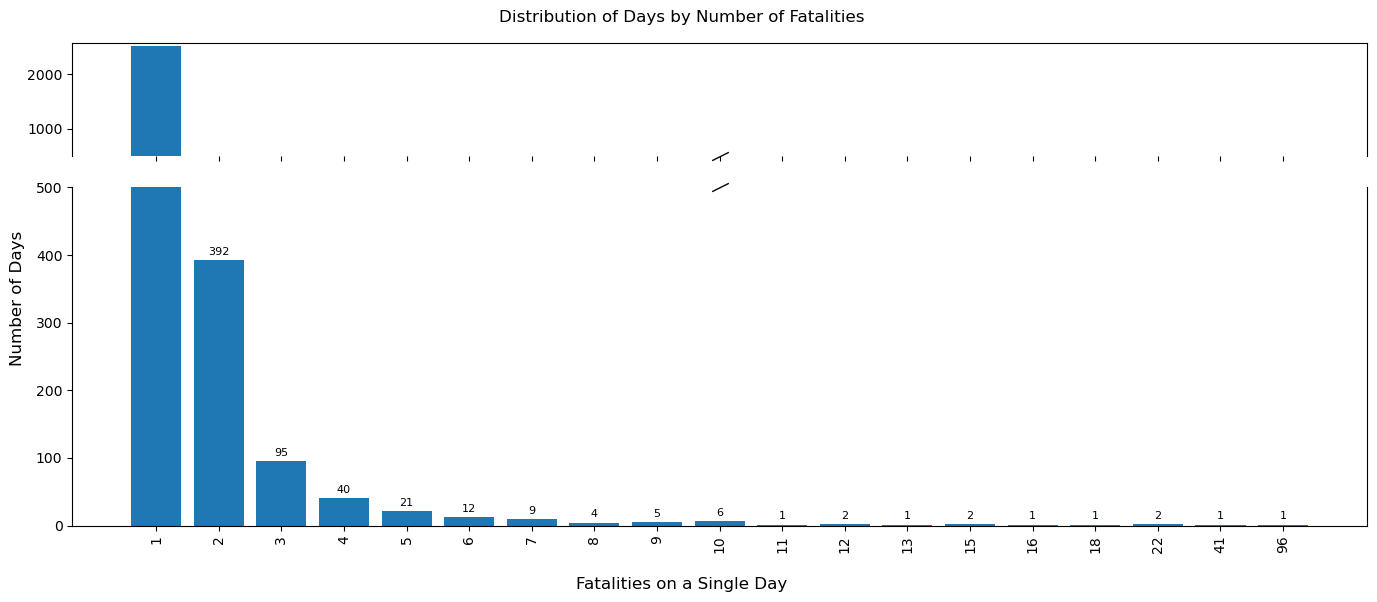

Total unique days with deaths: 3126

Day Buckets with total days and fatalities:
1 death: 2530 days, 2530 total fatalities
2-4 deaths: 527 days, 1229 total fatalities
5-9 deaths: 51 days, 317 total fatalities
10-19 deaths: 14 days, 172 total fatalities
20+ deaths: 4 days, 181 total fatalities


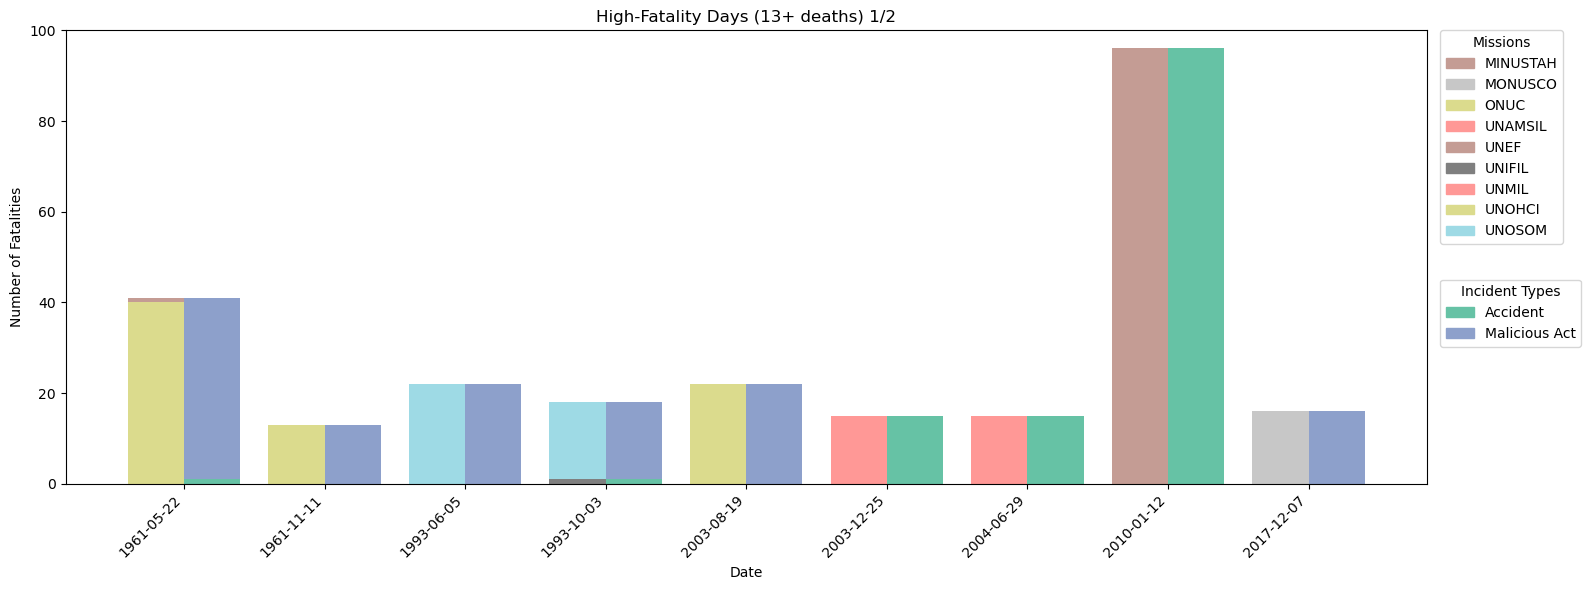

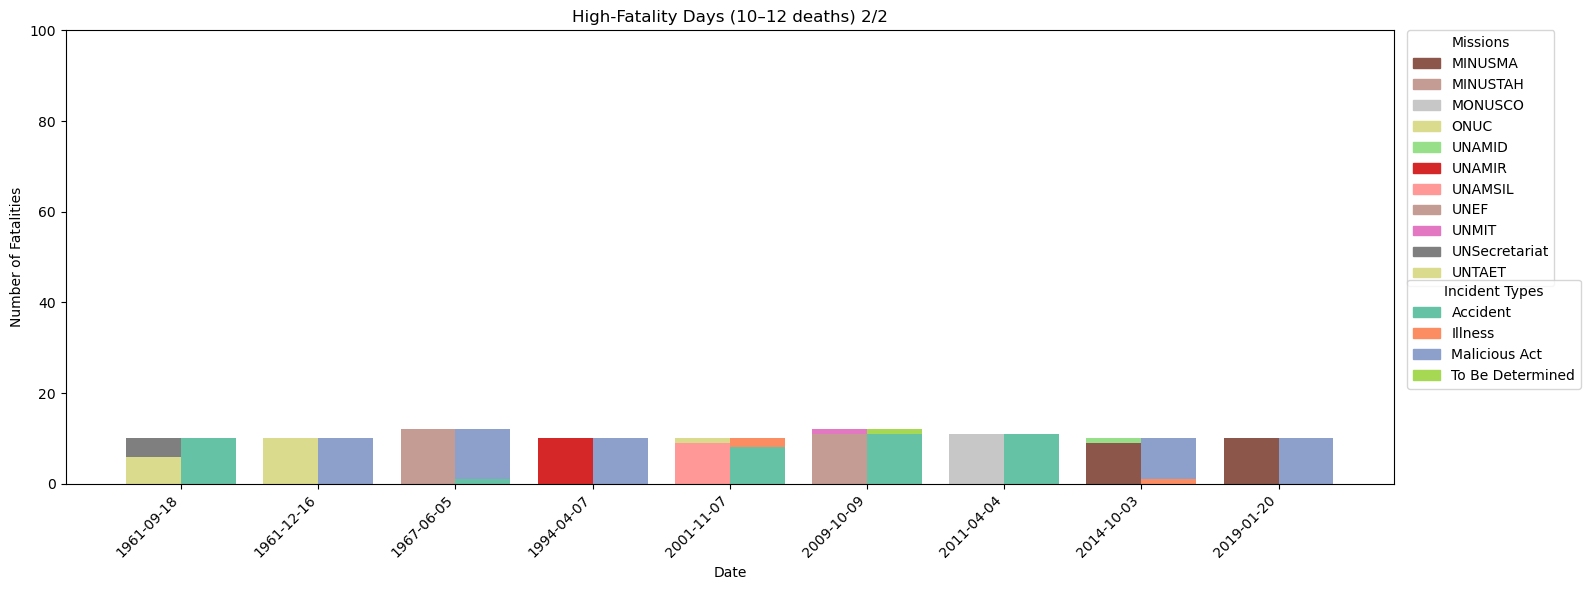

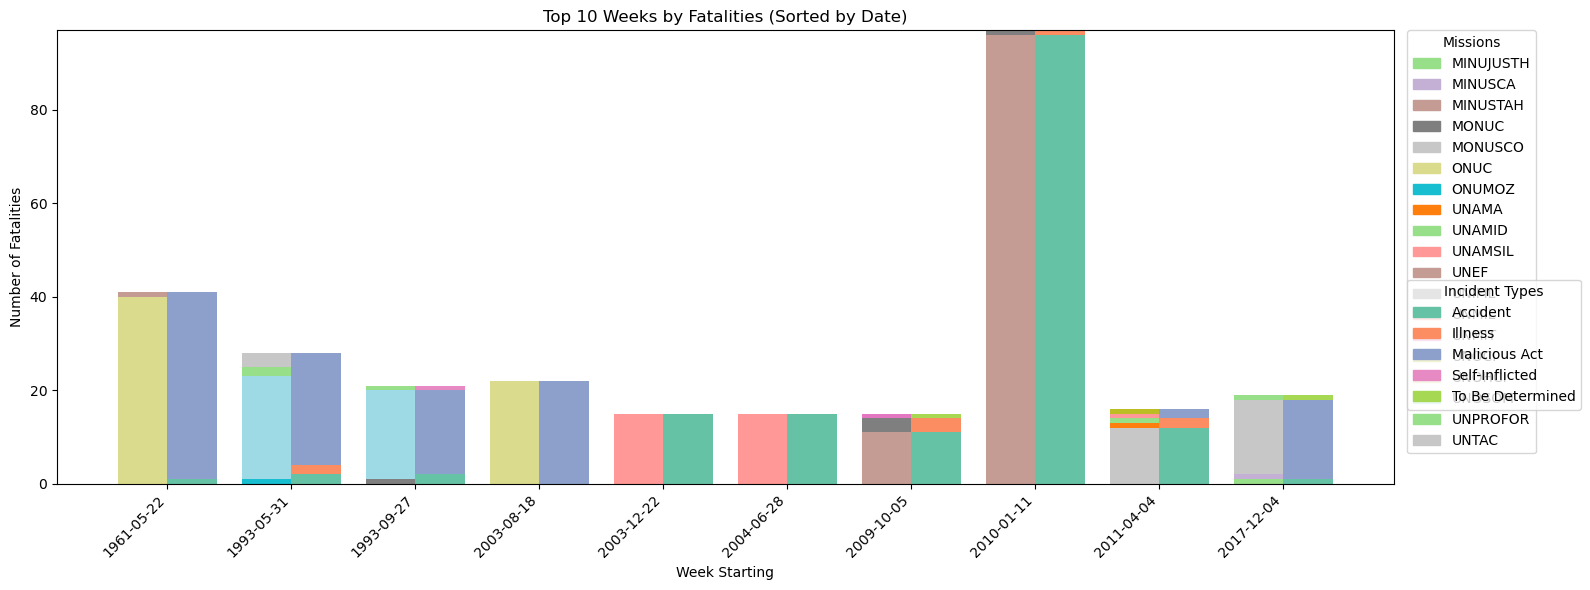

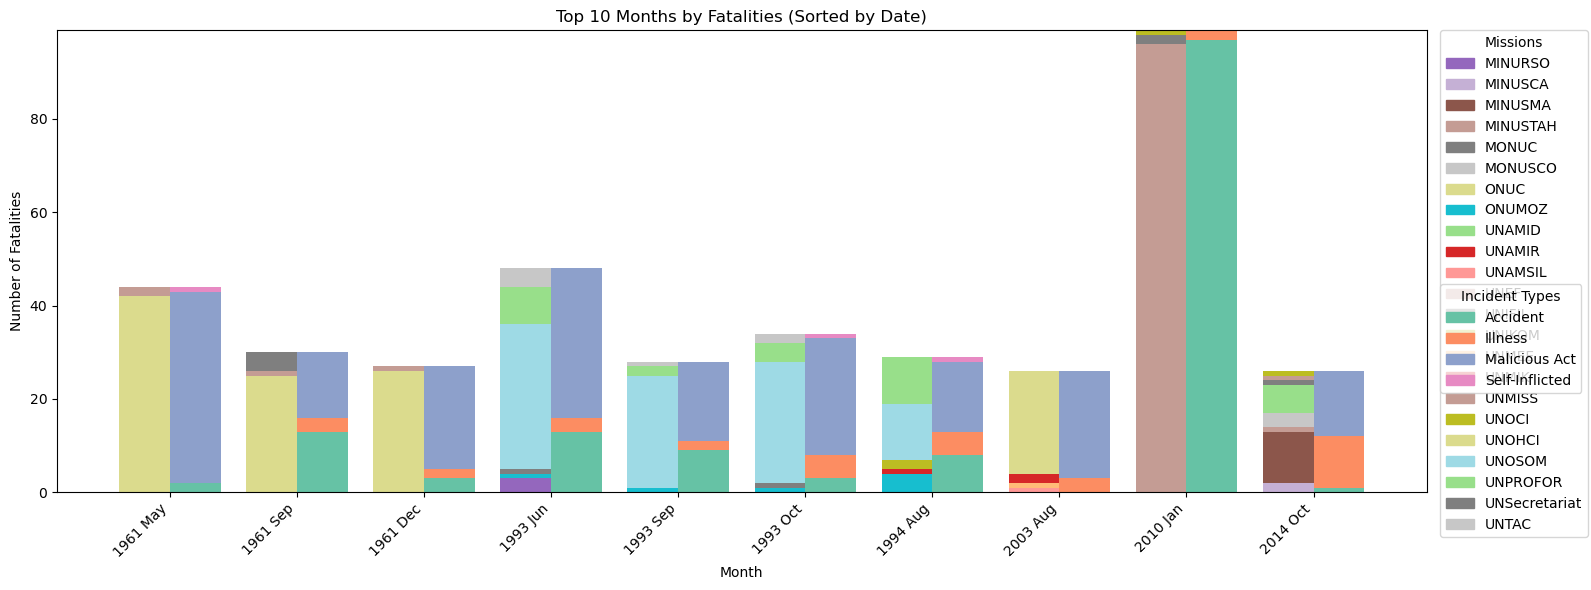

Cases with 3+ fatalities on the same day within the same mission:
     incident_date mission_acronym  fatalities
2057    2010-01-12        MINUSTAH          96
100     1961-05-22            ONUC          40
1427    2003-08-19          UNOHCI          22
767     1993-06-05          UNOSOM          22
823     1993-10-03          UNOSOM          17
...            ...             ...         ...
2268    2012-08-25          UNAMID           3
776     1993-06-21         MINURSO           3
2196    2011-10-10          UNAMID           3
784     1993-07-02          UNOSOM           3
3277    2023-02-21         MINUSMA           3

[157 rows x 3 columns]


In [112]:
# 1. How are casualties distributed across dates?

#1.1. Draw a bar chart of casualty count distribution. 
#The y-axis will be "broken" to accomodate a large difference between the number of days with 1 casualty, and the number of days with 2 and more casualties

fatality_distribution = df.groupby('incident_date').size().value_counts().sort_index()

# Determine where to break the y-axis
y_break = 500 
top_value = fatality_distribution.max()

# Plot with two y-axes
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(14, 6), gridspec_kw={'height_ratios': [1, 3]})

# Categorical x-axis labels (only unique counts)
x_labels = fatality_distribution.index
x = range(len(x_labels))
heights = fatality_distribution.values

# Top plot (zoomed out part for high values)
ax1.bar(x, heights)
ax1.set_ylim(y_break, top_value + 50)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(labelbottom=False)

# Bottom plot (normal part)
bars = ax2.bar(x, heights)
ax2.set_ylim(0, y_break)
ax2.spines['top'].set_visible(False)

# Add "break" markers
kwargs = dict(marker=[(-1, -0.5), (1, 0.5)], markersize=12,
              linestyle='none', color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0.5], [0], transform=ax1.transAxes, **kwargs)
ax2.plot([0.5], [1], transform=ax2.transAxes, **kwargs)

# Add labels above bars in lower plot
for bar in bars:
    height = bar.get_height()
    if height < y_break:
        ax2.text(bar.get_x() + bar.get_width()/2, height + 5, str(height),
                 ha='center', va='bottom', fontsize=8)

# Formatting
plt.xticks(ticks=x, labels=[str(i) for i in x_labels], rotation=90)
fig.suptitle("Distribution of Days by Number of Fatalities")
fig.supxlabel("Fatalities on a Single Day")
fig.supylabel("Number of Days")

plt.tight_layout()
plt.show()

#1.2. Put the days in buckets by casualty number
daily_counts = df.groupby('incident_date').size()

num_unique_days = daily_counts.shape[0]
print(f"Total unique days with deaths: {num_unique_days}")

buckets = {
    '1 death': daily_counts[daily_counts == 1],
    '2-4 deaths': daily_counts[(daily_counts >= 2) & (daily_counts <= 4)],
    '5-9 deaths': daily_counts[(daily_counts >= 5) & (daily_counts <= 9)],
    '10-19 deaths': daily_counts[(daily_counts >= 10) & (daily_counts <= 19)],
    '20+ deaths': daily_counts[daily_counts > 19],
}

print("\nDay Buckets with total days and fatalities:")
for label, series in buckets.items():
    print(f"{label}: {len(series)} days, {series.sum()} total fatalities")

# 2. Were there days with an exceptionally high number of casualties?

# 2.1. Ensure a Consistent Color Map
# --- Color dictionary for missions ---
unique_missions = sorted(df['mission_acronym'].dropna().unique())
cmap_missions = plt.get_cmap('tab20')
color_dict_missions = {mission: cmap_missions(i % cmap_missions.N) for i, mission in enumerate(unique_missions)}

# --- Color dictionary for incident types (new) ---
unique_incidents = sorted(df['type_of_incident'].dropna().unique())
cmap_incidents = plt.get_cmap('Set2')  # or 'Set3', 'Pastel1'
color_dict_incidents = {inc: cmap_incidents(i % cmap_incidents.N) for i, inc in enumerate(unique_incidents)}

# 2.2. General Plotting Function ---
def plot_dual_stacked(df, time_col, title, xlabel, color_dict_missions, color_dict_incidents, top_n=10, ymax=None):
    # Mission grouping
    g1 = df.groupby([time_col, 'mission_acronym']).size().unstack(fill_value=0)

    # Incident grouping
    g2 = df.groupby([time_col, 'type_of_incident']).size().unstack(fill_value=0)

    # Take top N periods based on total deaths
    top_periods = g1.sum(axis=1).nlargest(top_n).sort_index()
    g1 = g1.loc[top_periods.index]
    g2 = g2.loc[top_periods.index]

    # Format x labels
    if time_col == 'month':
        x_labels = top_periods.index.strftime('%Y %b')
    else:
        x_labels = top_periods.index.strftime('%Y-%m-%d')

    # Prepare plot
    fig, ax = plt.subplots(figsize=(16, 6))
    x = np.arange(len(top_periods.index))  # Number of periods

    bar_width = 0.4

    # Colors
    color_missions = [color_dict_missions.get(m, '#999999') for m in g1.columns]
    color_incidents = [color_dict_incidents.get(i, '#666666') for i in g2.columns]

    # Plot mission bars
    bottoms = np.zeros(len(x))
    for i, col in enumerate(g1.columns):
        values = g1[col].values
        ax.bar(x - bar_width/2, values, bottom=bottoms, width=bar_width, label=col,
               color=color_missions[i])
        bottoms += values
    
    # Plot incident bars
    bottoms = np.zeros(len(x))
    for i, col in enumerate(g2.columns):
        values = g2[col].values
        ax.bar(x + bar_width/2, values, bottom=bottoms, width=bar_width, label=col,
               color=color_incidents[i])
        bottoms += values
    if ymax is not None:
        ax.set_ylim(0, ymax)
    
    # Format
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Number of Fatalities")
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')

    # Create separate legends
    from matplotlib.patches import Patch
    used_missions = [m for m in g1.columns if g1[m].sum() > 0]
    used_incidents = [i for i in g2.columns if g2[i].sum() > 0]

    legend_mission_patches = [Patch(color=color_dict_missions[m], label=m) for m in used_missions]
    legend_incident_patches = [Patch(color=color_dict_incidents[i], label=i) for i in used_incidents]

    legend1 = ax.legend(handles=legend_mission_patches, title='Missions',
                    bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    ax.add_artist(legend1)  # <- Add first legend manually so it's not overwritten

    legend2 = ax.legend(handles=legend_incident_patches, title='Incident Types',
                    bbox_to_anchor=(1.01, 0.45), loc='upper left', borderaxespad=0.)

    
    plt.tight_layout()
    plt.show()


# 2.3. Plot High-Fatality Days (Split in two graphs for legibility)
days_13plus = daily_counts[daily_counts >= 13].index
days_10_12 = daily_counts[(daily_counts >= 10) & (daily_counts <= 12)].index

df_13plus = df[df['incident_date'].isin(days_13plus)]
df_10_12 = df[df['incident_date'].isin(days_10_12)]

plot_dual_stacked(
    df_13plus,
    time_col='incident_date',
    title='High-Fatality Days (13+ deaths) 1/2',
    xlabel='Date',
    color_dict_missions=color_dict,
    color_dict_incidents=color_dict_incidents,
    ymax=100
)

plot_dual_stacked(
    df_10_12,
    time_col='incident_date',
    title='High-Fatality Days (10–12 deaths) 2/2',
    xlabel='Date',
    color_dict_missions=color_dict,
    color_dict_incidents=color_dict_incidents,
    ymax=100  # same scale for comparison
)


# 2.4. Top 20 Weeks and Months by Fatalities (Sorted by Date)

# Add week/month columns 
df['week'] = df['incident_date'].dt.to_period('W').apply(lambda r: r.start_time)
df['month'] = df['incident_date'].dt.to_period('M').apply(lambda r: r.start_time)

#plot_top_stacked(
#    df,
#    time_col='incident_date',
#    title='Top 20 Single Days by Fatalities (Sorted by Date)',
#    xlabel='Date',
#    color_dict=color_dict,
#    top_n=20
#)

plot_dual_stacked(
    df,
    time_col='week',
    title='Top 10 Weeks by Fatalities (Sorted by Date)',
    xlabel='Week Starting',
    color_dict_missions=color_dict,
    color_dict_incidents=color_dict_incidents,
    top_n=10
)

plot_dual_stacked(
    df,
    time_col='month',
    title='Top 10 Months by Fatalities (Sorted by Date)',
    xlabel='Month',
    color_dict_missions=color_dict,
    color_dict_incidents=color_dict_incidents,
    top_n=10
)

# 3. Identify events where a single mission on a single day had 3+ casualties

cases_3plus = (
    df.groupby(['incident_date', 'mission_acronym'])
      .size()
      .reset_index(name='fatalities')
)

cases_3plus = cases_3plus[cases_3plus['fatalities'] >= 3]

print("Cases with 3+ fatalities on the same day within the same mission:")
print(cases_3plus.sort_values(by='fatalities', ascending=False))


Looking at these graphs, we see that there were several high-casualty days in UN peacekeeping history. Among those are (sources: Wikipedia + chatgpt):

## ONUC

### 1961-05-22

In 1961, during the UN peacekeeping mission in the Congo (ONUC), UN personnel — Ghanaian soldiers and two British officers — were killed in Port Francqui (now Ilebo) after tensions escalated between the UN and Congolese National Army (ANC) troops. The violence was triggered by a speech from a Congolese minister accusing the ANC of misconduct and threatening disarmament by the UN. Enraged ANC soldiers retaliated by attacking the scattered and unprepared UN garrison, killing many peacekeepers in what became one of the deadliest single incidents in UN peacekeeping history. [Source 1](https://www.ghanaweb.com/GhanaHomePage/NewsArchive/Today-in-History-How-43-Ghanaian-peacekeepers-were-killed-by-Congolese-army-936436), [source 2](https://iunva.ie/mass-murder-un-peacekeepers-in-the-congo-april-1961). 

Although both sources date this attack to April 28, the database attributes 40 related ONUC fatalities — including 38 Ghanaian and 2 UK personnel — to May 22, 1961, suggesting either a reporting delay or retrospective data correction. This is further supported by their casualty IDs, all of which follow the pattern "ONUC-1961-05-xxxxx," indicating they were officially recorded as May deaths.
The database has 4 ONUC casualties on April 28, 1961: two Ghanaian and two Swedish military personnel.

### 1961-09-18

On September 18, 1961, United Nations Secretary-General Dag Hammarskjöld died in a plane crash near Ndola, in Northern Rhodesia (now Zambia), while en route to negotiate a ceasefire during the Congo Crisis. The crash claimed the lives of all 16 people on board, including Hammarskjöld and his staff. The aircraft, a Douglas DC-6B registered as SE-BDY, was operated by Transair Sweden for the United Nations. [Source](https://en.wikipedia.org/wiki/1961_Ndola_Transair_Sweden_DC-6_crash).

### 1961-11-11

On November 11, 1961, during the United Nations Operation in the Congo (ONUC), thirteen Italian Air Force personnel were brutally killed in what became known as the Kindu Atrocity. The Italian airmen, operating two C-119 transport aircraft, were on a routine mission delivering supplies to the Malaysian UN contingent stationed near Kindu in eastern Congo. Upon landing, they were seized by Congolese soldiers loyal to the pro-Lumumba faction led by Antoine Gizenga. Misinformation had spread among these troops, leading them to believe that the Italians were delivering arms to secessionist forces in Katanga. Despite being unarmed and part of a peacekeeping mission, the airmen were executed, and their bodies were mutilated by a local mob. [Source](https://en.wikipedia.org/wiki/Kindu_atrocity).

### 1961-12-16

On December 16, 1961, during the United Nations Operation in the Congo (ONUC), UN peacekeepers engaged in significant combat operations as part of Operation Unokat, aimed at ending the secession of Katanga province.
One notable engagement was the Attack on Camp Massart, the main base of the Katangese Gendarmerie in Élisabethville. Swedish troops led the assault, supported by Irish, Indian, and Ethiopian contingents. The operation began in the early hours and concluded by 1 p.m. with the capture of the camp. Casualties included one Swedish soldier killed and five wounded, while Katangese forces suffered 10–20 fatalities, with additional wounded and prisoners taken.
Simultaneously, Irish forces from the 36th Battalion attacked a strategically vital railway tunnel near Élisabethville, held by Katangese troops and mercenaries. The tunnel was successfully secured, but three Irish soldiers—Lieutenant Patrick Riordan, Private Andrew Wickham, and another unnamed soldier—lost their lives during the assault.
These engagements were part of a broader ONUC offensive that, over several days, resulted in the deaths of 21 UN personnel and injuries to 84 others. Katangese forces suffered between 206 and 500 fatalities, with many more wounded.
The operations on December 16 were pivotal in diminishing the military capabilities of the Katangese secessionists and set the stage for subsequent negotiations, including the Kitona Declaration, which aimed to reintegrate Katanga into the Republic of the Congo. [Source](https://en.wikipedia.org/wiki/Operation_Unokat).


## UNEF

### 1967-06-05

On June 5, 1967, during the outbreak of the Six-Day War, Israeli forces attacked United Nations Emergency Force (UNEF) positions in three separate incidents: a UNEF convoy, camps where personnel were concentrated, and the UNEF headquarters in Gaza. These attacks resulted in the deaths of one Brazilian peacekeeper and 14 Indian officials, with an additional 17 peacekeepers from both contingents wounded. [Source](https://en.wikipedia.org/wiki/Six-Day_War).

## UNOSOM

### 1993-06-05

On June 5, 1993, during the United Nations Operation in Somalia II (UNOSOM II), 24 Pakistani peacekeepers were killed and 57 wounded in Mogadishu when Somali militias and civilians attacked UN forces conducting a weapons inspection at Radio Mogadishu, a site controlled by General Mohamed Farrah Aidid's Somali National Alliance (SNA). The incident, known as the June 1993 attack on Pakistani military in Somalia, was reportedly triggered by rumors that UNOSOM intended to shut down the station, which had been broadcasting anti-UN messages. The attack marked a turning point in the mission, leading the UN Security Council to pass Resolution 837 the following day, authorizing all necessary measures to apprehend those responsible. [Source](https://en.wikipedia.org/wiki/June_1993_attack_on_Pakistani_military_in_Somalia).

### 1993-10-03

On October 3, 1993, during the Battle of Mogadishu, United Nations peacekeeping forces operating under UNOSOM II suffered multiple casualties during a U.S.-led mission to capture key lieutenants of Somali warlord Mohamed Farrah Aidid. While U.S. troops were operating with a dual role—formally under U.S. command but within the UNOSOM II framework—their mission, Operation Gothic Serpent, was not directly commanded by the UN. In the ensuing 15-hour battle, 18 U.S. soldiers were killed and 84 wounded. Additionally, one Malaysian UN peacekeeper was killed, and seven Malaysian and two Pakistani UN peacekeepers were wounded during the rescue and extraction efforts, which were coordinated in part by UN forces. [Source](https://en.wikipedia.org/wiki/Battle_of_Mogadishu_%281993%29).
The database lists 22 UNOSOM casualties on 03 and 04 October 1993: 19 American, 1 Belgian, 1 Malaysian (causes of death - Malicious act), and 1 undetermined (cause of death - Accident).


## UNAMIR

### 1994-04-07

On April 7, 1994, the day after the assassination of Rwandan President Juvénal Habyarimana, ten Belgian peacekeepers serving with the United Nations Assistance Mission for Rwanda (UNAMIR) were brutally murdered in Kigali. These soldiers had been assigned to protect Prime Minister Agathe Uwilingiyimana, who was also killed that morning by Rwandan government forces. The peacekeepers were disarmed, taken to Camp Kigali, and killed by soldiers of the Rwandan Armed Forces. This incident was a calculated move by Hutu extremists to provoke Belgium into withdrawing its troops, thereby weakening the UN mission's capacity to respond to the escalating violence. The murders of the Belgian peacekeepers and the Prime Minister marked the beginning of the Rwandan genocide, during which an estimated 800,000 Tutsi and moderate Hutu were killed over approximately 100 days. [Source](https://en.wikipedia.org/wiki/Initial_events_of_the_Rwandan_genocide).


## UNAMSIL

### 2001-11-07
On November 7, 2001, a United Nations Mi-8 transport helicopter serving with the UN Mission in Sierra Leone (UNAMSIL) crashed into the Atlantic Ocean shortly after takeoff from Freetown, killing all seven people on board. The victims included four Ukrainian crew members from Ukraine’s 20th Separate Helicopter Detachment, two Zambian military officers, and one Bulgarian UN air operations officer. [Source](https://www.thenewhumanitarian.org/news/2001/11/08/seven-die-un-helicopter-crash).


### 2003-12-25

On December 25, 2003, a tragic aviation accident occurred near Cotonou, Benin, resulting in the deaths of over 130 individuals, including 15 United Nations peacekeepers from Bangladesh. The peacekeepers were traveling aboard a Boeing 727 operated by Union Transport Africaines (UTA) when the aircraft crashed into the sea shortly after takeoff from Cotonou's airport. Among the deceased were 13 officers serving with the United Nations Mission in Sierra Leone (UNAMSIL) and 2 with the United Nations Mission in Liberia (UNMIL). [Source](http://peacekeeping.un.org/mission/past/unamsil/db020104.pdf).

### 2004-06-29

On June 29, 2004, a tragic helicopter crash in Sierra Leone resulted in the deaths of 24 individuals, including United Nations peacekeepers. The Russian Mi-8 MTV-1 helicopter, leased by the UN peacekeeping mission, was en route from Freetown to the eastern town of Yengema when it crashed into a hillside in dense jungle approximately five minutes before its scheduled landing. All aboard perished, including 14 Pakistani soldiers, several other foreign nationals, three Russian crew members, and three Sierra Leoneans. [Source](https://www.aljazeera.com/news/2004/6/30/un-staff-killed-in-west-african-air-crash).


## UNOHCI

### 2003-08-19

On August 19, 2003, a suicide truck bombing devastated the United Nations headquarters at the Canal Hotel in Baghdad, Iraq, killing 22 people and injuring over 100. Among the dead was Sérgio Vieira de Mello, the UN's Special Representative in Iraq and High Commissioner for Human Rights. The attack, claimed by Abu Musab al-Zarqawi's group Jama'at al-Tawhid wal-Jihad, marked the deadliest single assault on UN personnel at that time and led to the withdrawal of most UN staff from Iraq. This tragedy prompted a comprehensive overhaul of UN security protocols and inspired the designation of August 19 as World Humanitarian Day to honor those who risk their lives in humanitarian service. [Source](https://en.wikipedia.org/wiki/Canal_Hotel_bombing).



## MINUSTAH

### 2009-10-09

On October 9, 2009, a tragic aviation accident occurred in Haiti, resulting in the deaths of 11 United Nations peacekeepers. A UN plane crashed in the city of Ganthier, claiming the lives of all personnel on board. [Source](https://www.nytimes.com/2009/10/10/world/americas/10haiti.html) 

### 2010-01-12

On January 12, 2010, a catastrophic 7.0 magnitude earthquake struck near Port-au-Prince, Haiti, causing widespread devastation and a significant loss of life. The disaster resulted in the deaths of an estimated 230,000 to 316,000 people and injured over 300,000 others. Approximately 1.5 million individuals were displaced, and countless buildings, including hospitals, schools, and government facilities, were destroyed or severely damaged.

Among the victims were 102 United Nations personnel, marking the deadliest single event for UN peacekeepers in the organization's history. The earthquake caused the collapse of the Christopher Hotel, which served as the headquarters for the United Nations Stabilization Mission in Haiti (MINUSTAH). This tragic event claimed the lives of several high-ranking UN officials, including:
Hédi Annabi (Tunisia), Special Representative of the Secretary-General and Head of MINUSTAH
Luiz Carlos da Costa (Brazil), Principal Deputy Special Representative
Doug Coates (Canada), Acting UN Police Commissioner

Additionally, eight Chinese peacekeepers and police officers perished while attending a meeting at the UN headquarters when the earthquake struck. Other UN casualties included personnel from countries such as Argentina, Benin, Jordan, the Philippines, and Nigeria.

The destruction of the UN headquarters severely hampered the organization's ability to coordinate relief efforts during the critical initial response period. Despite the loss, surviving UN staff, along with international partners, mobilized to provide humanitarian assistance, security, and support for Haiti's recovery. [Source](https://en.wikipedia.org/wiki/United_Nations_Stabilisation_Mission_in_Haiti).

## MONUSCO

### 2011-04-04

On April 4, 2011, Georgian Airways Flight 834, operating on behalf of the United Nations Organization Stabilization Mission in the Democratic Republic of the Congo (MONUSCO), crashed while attempting to land at N'djili Airport in Kinshasa, DRC. The aircraft, a Bombardier CRJ100, was carrying 29 passengers and 4 crew members. Tragically, 32 individuals lost their lives in the accident, with only one passenger surviving.

The passengers comprised UN peacekeepers and officials, humanitarian workers, and electoral assistants from various UN entities, including MONUSCO, the United Nations Development Programme (UNDP), the UN Office for the Coordination of Humanitarian Affairs (OCHA), the World Food Programme (WFP), and the United Nations Office for Project Services (UNOPS). Additionally, staff from non-governmental organizations and international bodies, such as the Congolese government, the electoral commission, the International Criminal Court, the International Rescue Committee, and Pacific Architects and Engineers, were on board.

The individuals hailed from 14 different countries, including the Democratic Republic of the Congo, South Africa, Bangladesh, Belgium, Côte d'Ivoire, Mali, Benin, Burkina Faso, Ghana, Haiti, Kenya, Mauritania, São Tomé and Príncipe, and Senegal. All four crew members were Georgian nationals.

This incident stands as one of the deadliest aviation accidents involving UN personnel, highlighting the significant risks faced by peacekeepers and humanitarian workers in conflict and post-conflict zones. [Source](https://en.wikipedia.org/wiki/Georgian_Airways_Flight_834).

### 2017-12-07

On December 7, 2017, the United Nations Organization Stabilization Mission in the Democratic Republic of the Congo (MONUSCO) suffered one of its deadliest attacks when its base near the Semuliki River in North Kivu was assaulted by suspected militants from the Allied Democratic Forces (ADF). This coordinated attack resulted in the deaths of 15 Tanzanian peacekeepers and injuries to 53 others, marking the most significant loss for UN peacekeeping forces since the 1993 ambush in Somalia. [Source](https://en.wikipedia.org/wiki/2017_Semuliki_attack).

## MINUSMA

### 2014-10-03
On October 3, 2014, nine Nigerien peacekeepers serving with the United Nations Multidimensional Integrated Stabilization Mission in Mali (MINUSMA) were killed in an ambush near Indelimane, in the Gao Region of Mali. The peacekeepers were part of a convoy conducting a supply mission between Ansongo and Ménaka when they were attacked by jihadists affiliated with al-Mourabitoun. The assailants, riding motorcycles and armed with RPG-7s, destroyed two vehicles and a tank before fleeing the scene. This attack marked the deadliest incident against MINUSMA since its deployment in Mali. [Source](https://en.wikipedia.org/wiki/2014_Indelimane_ambush).

### 2019-01-20

On January 20, 2019, the United Nations Multidimensional Integrated Stabilization Mission in Mali (MINUSMA) base in Aguelhok, northern Mali, was attacked by approximately 150 militants from Jama'at Nasr al-Islam wal Muslimin (JNIM), an al-Qaeda-affiliated group. The assault began at dawn, with the attackers arriving in about 15 armed vehicles and launching a coordinated offensive from three directions. The base, defended by Chadian and Bangladeshi peacekeepers, faced intense fighting that lasted several hours. The confrontation resulted in the deaths of 11 Chadian peacekeepers and injuries to 26 others. [Source](https://en.wikipedia.org/wiki/2019_Aguelhok_attack).



# Decades trends

Now let us look at the decade-to-decade changes in the composition of fatalities:

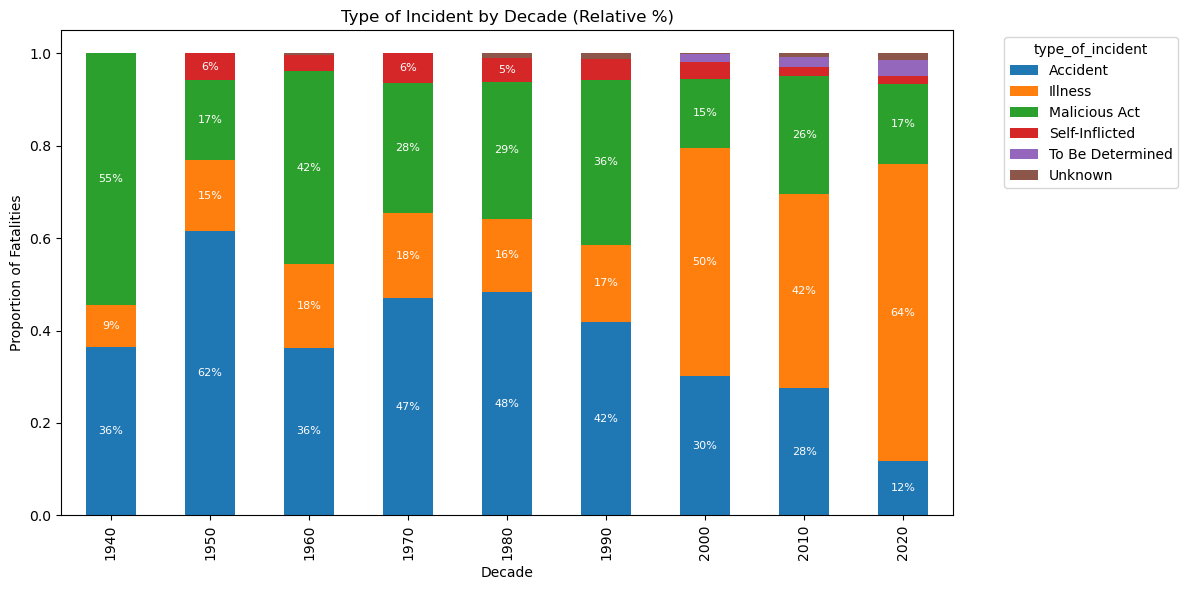

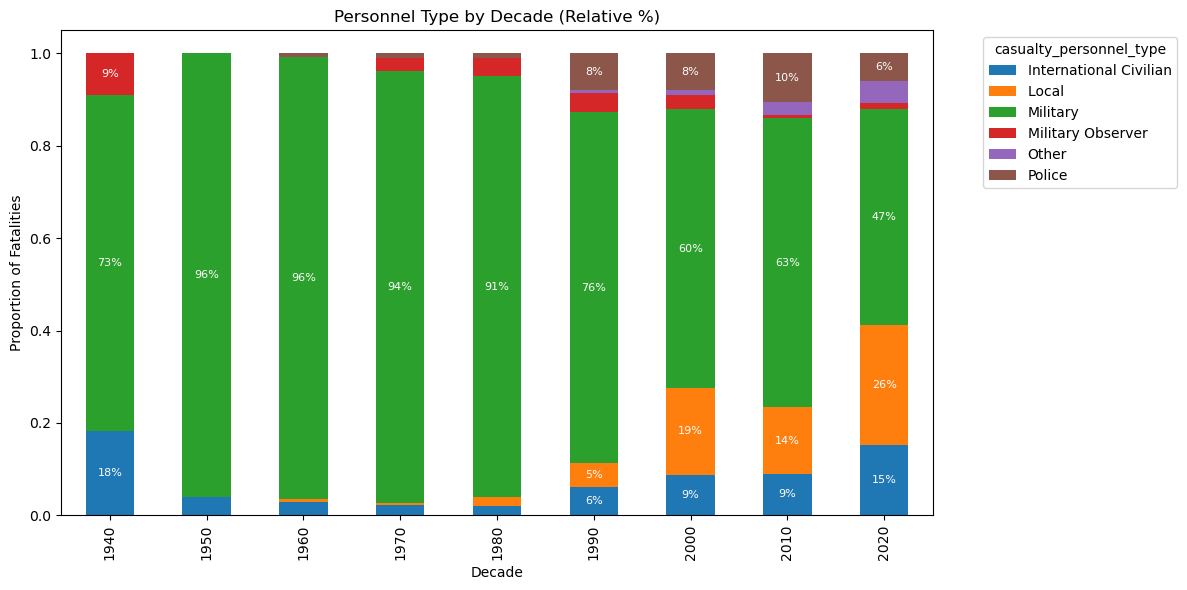

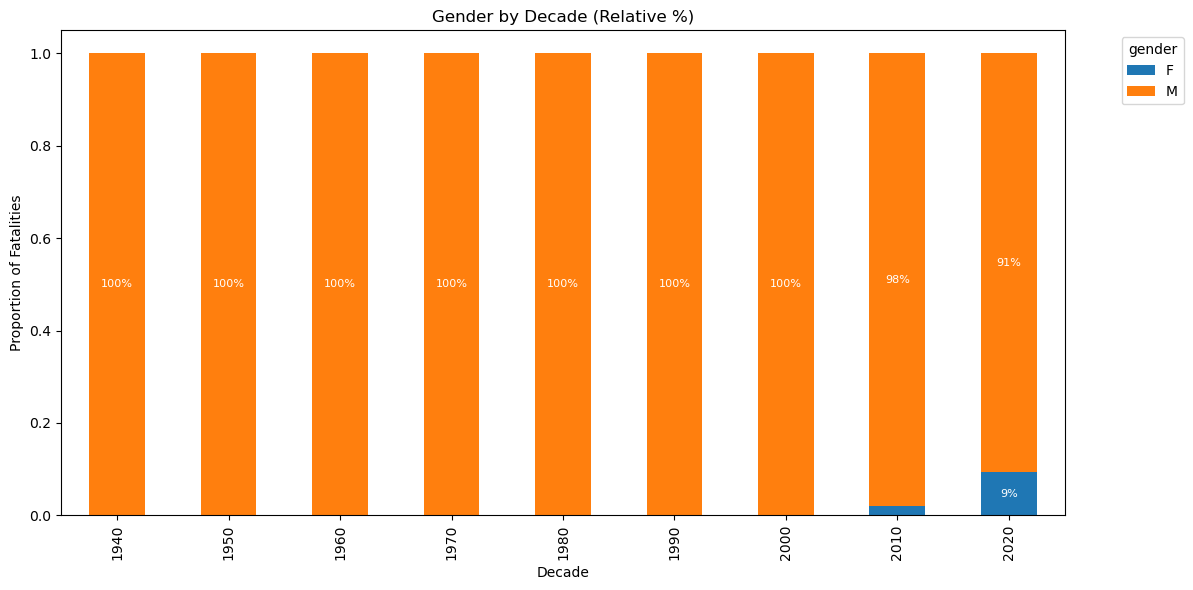

In [114]:
# Add 'decade' column
df['year'] = df['incident_date'].dt.year
df['decade'] = (df['year'] // 10) * 10
df = df[df['decade'].between(1940, 2029)]

# Function to plot stacked bars with percentage labels
def plot_relative_stacked_bar(data, group_col, title):
    grouped = data.groupby(['decade', group_col]).size().unstack(fill_value=0)
    relative = grouped.div(grouped.sum(axis=1), axis=0)

    ax = relative.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title(f'{title} by Decade (Relative %)')
    plt.xlabel('Decade')
    plt.ylabel('Proportion of Fatalities')
    plt.legend(title=group_col, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add value annotations
    for i, decade in enumerate(relative.index):
        cumulative = 0
        for j, col in enumerate(relative.columns):
            height = relative.loc[decade, col]
            if height > 0.05:  # Only label if segment is large enough
                plt.text(i, cumulative + height / 2, f'{height:.0%}',
                         ha='center', va='center', fontsize=8, color='white')
            cumulative += height

    plt.tight_layout()
    plt.show()

# Plot all 3 groupings
plot_relative_stacked_bar(df, 'type_of_incident', 'Type of Incident')
plot_relative_stacked_bar(df, 'casualty_personnel_type', 'Personnel Type')
plot_relative_stacked_bar(df, 'gender', 'Gender')


We see that
- Starting in the 2000s, the share of deaths from illness started growing. This can reflect either that UN has been having increasingly more missions in tropical countries, or that more UN missions started taking place in less violent contexts.
- The share of local personnel in the total casualties started growing in 1990s. This reflects the UN policy change of attracting more local personnel for its missions.
- The share of female casualties grew in 2010s and 2020s. This also illustrates the UN policy change of encouraging women's participation in the peacekeeping missions, which started with the UN Security Council's Resolution 1325 in 2000.

# Illnesses

Illnesses are the leading cause of deaths in the UN peacekeeping missions, starting from 2000s. Let us look if missions in tropical countries are more prone to illnesses. We will use the list of countries obtained in our [main notebook](./un_peacekeepers.ipynb).

We use chatgpt to create a dummy variable 'has_malaria' and construct the bar chart with malaria-endemic countries red and non malaria_endemic countries blue.

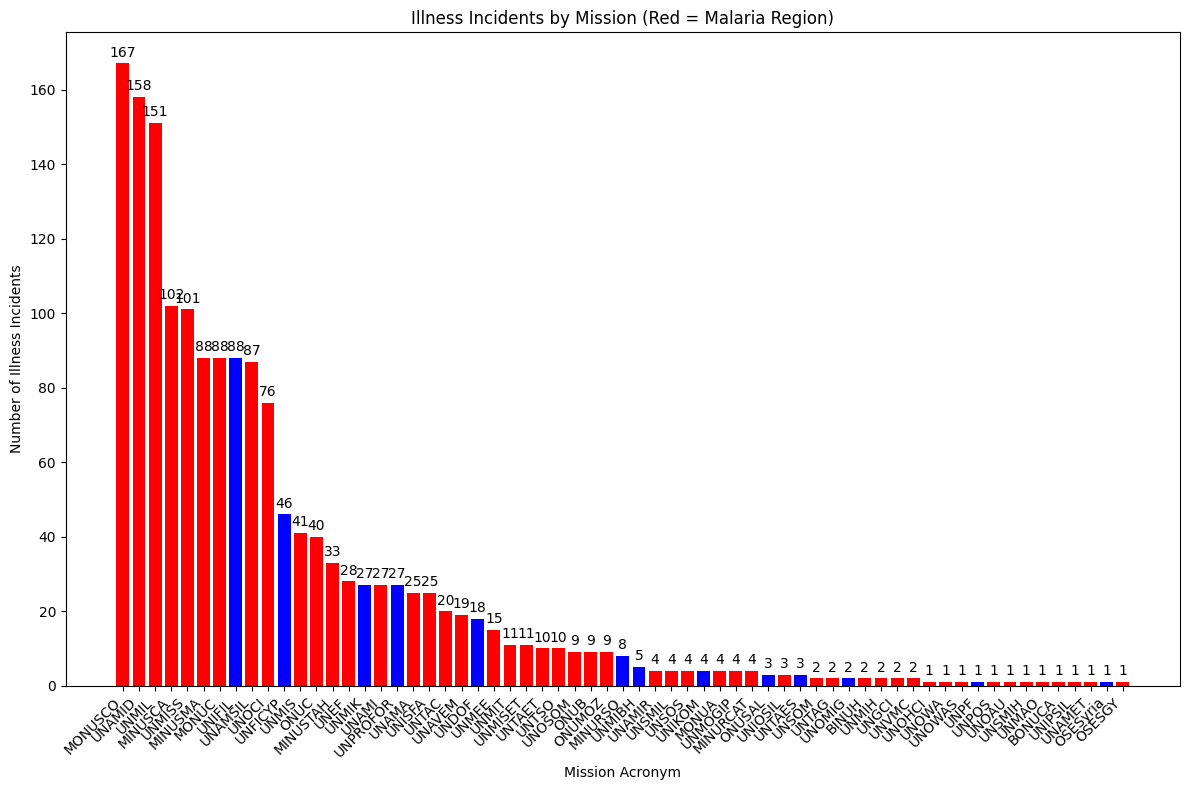

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from preprocessing import send_to_chatgpt
import time

# Step 1: Load the dataset with missions and countries
csv_url = 'https://drive.google.com/uc?export=download&id=1QpgbW8SOuHJVqzMPpNk0nBq1zrrh2jHn'
missions_df = pd.read_csv(csv_url)

# Step 2: Ask GPT about malaria risk
prompt_template = (
    "You are given a country or a list of countries. "
    "Does this country or at least one of these countries have malaria? "
    "Answer only 1 if yes or 0 if no.\n\nCountries: {}"
)

malaria_answers = []

for countries in missions_df['countries_of_operation']:
    attempt = 0
    result = None
    while attempt < 3:
        try:
            prompt = prompt_template.format(countries)
            response = send_to_chatgpt(model="gpt-4o", text=prompt, temperature=0, max_tokens=10)
            clean = response.strip().replace(".", "").split()[0]
            if clean in ['0', '1']:
                result = int(clean)
                break
        except Exception:
            pass
        attempt += 1
        time.sleep(1)  # to be gentle with rate limits
    malaria_answers.append(result if result is not None else "Error")

missions_df['has_malaria'] = malaria_answers

# save the malaria check results
# missions_df.to_excel("missions_with_malaria_check.xlsx", index=False)

# Step 3: Load the main dataset and merge by `mission_acronym`
incident_url = 'https://drive.google.com/uc?export=download&id=1YTJ2V4vfMRSBIkoGl17EUlgnDP-9vZMp'
df = pd.read_csv(incident_url, parse_dates=['incident_date'])

df = df.merge(missions_df[['mission_acronym', 'has_malaria']], on='mission_acronym', how='left')

# Step 4: Count illness cases by mission
illness_counts = (
    df[df['type_of_incident'] == 'Illness']
    .groupby(['mission_acronym', 'has_malaria'])
    .size()
    .reset_index(name='illness_count')
    .sort_values(by='illness_count', ascending=False)
)

# Step 5: Plot 
colors = ['red' if malaria == 1 else 'blue' for malaria in illness_counts['has_malaria']]

plt.figure(figsize=(12, 8))
bars = plt.bar(
    illness_counts['mission_acronym'],
    illness_counts['illness_count'],
    color=colors
)

plt.xlabel("Mission Acronym")
plt.ylabel("Number of Illness Incidents")
plt.title("Illness Incidents by Mission (Red = Malaria Region)")
plt.xticks(rotation=45, ha='right')

# Add labels
for bar, label in zip(bars, illness_counts['illness_count']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(label), ha='center', va='bottom')

plt.tight_layout()
plt.savefig("illness_by_mission_bar_chart.png", dpi=300)
plt.show()


The graph clearly shows that illness deaths occur predominantly in malaria-prone countries.

# Accidents, Malicious Acts and Self-inflicted

Let's calculate two key metrics: the Gini coefficient to assess how unevenly deaths from each cause are distributed across different missions, and the mean temporal distance to measure how closely in time these deaths occur.

First, let's measure the Gini coefficient

   type_of_incident  gini_coefficient
0          Accident          0.714755
1           Illness          0.760488
2     Malicious Act          0.810482
3    Self-Inflicted          0.793460
4  To Be Determined          0.868724
5           Unknown          0.837191


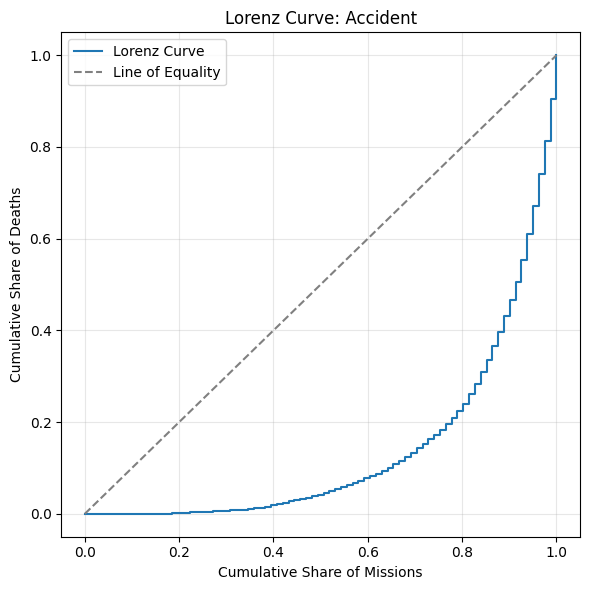

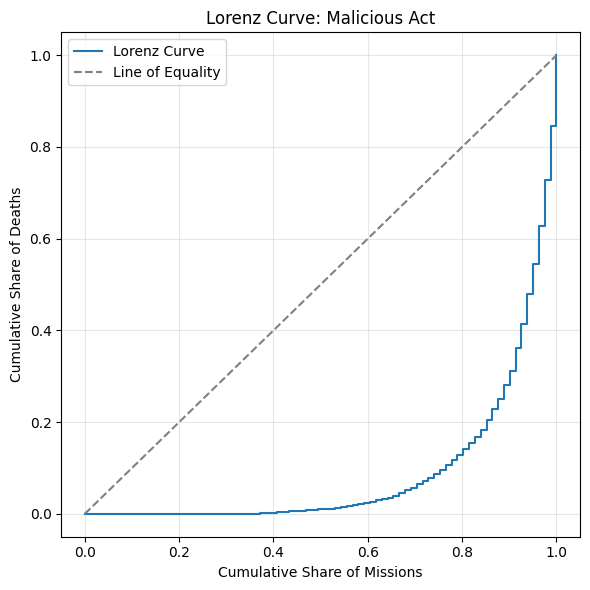

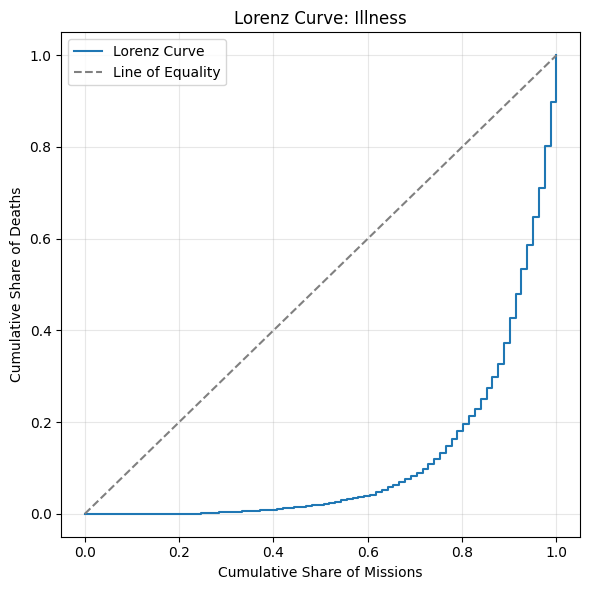

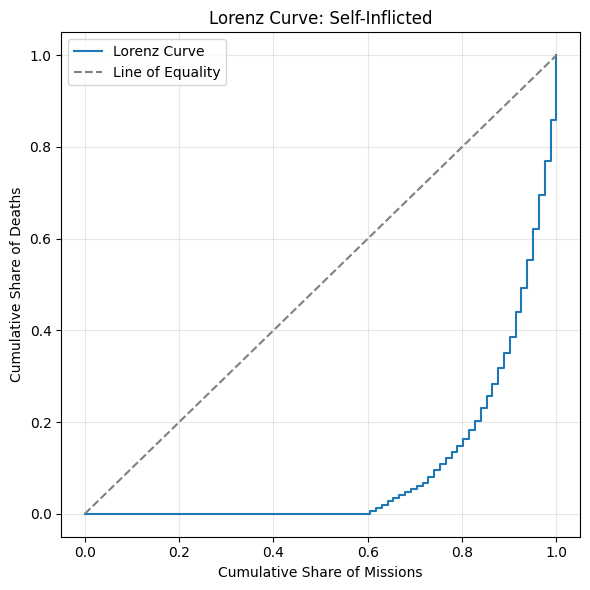

In [32]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

def calculate_gini_by_incident():
    # Step 1: Load data
    url = 'https://drive.google.com/uc?export=download&id=1YTJ2V4vfMRSBIkoGl17EUlgnDP-9vZMp'
    df = pd.read_csv(url, parse_dates=['incident_date'])

    # Step 2: Clean mission names
    df['mission_acronym'] = df['mission_acronym'].astype(str).fillna('Unknown')

    # Step 3: Prepare grid of all combinations
    missions = df['mission_acronym'].unique()
    incident_types = df['type_of_incident'].unique()
    full_index = pd.DataFrame(
        list(itertools.product(incident_types, missions)),
        columns=['type_of_incident', 'mission_acronym']
    )

    # Step 4: Count deaths
    death_counts = (
        df.groupby(['type_of_incident', 'mission_acronym'])
        .size()
        .reset_index(name='deaths')
    )

    # Step 5: Merge with full index to include zeros
    death_counts_full = pd.merge(full_index, death_counts,
                                 on=['type_of_incident', 'mission_acronym'], how='left')
    death_counts_full['deaths'] = death_counts_full['deaths'].fillna(0)

    # Step 6: Gini function
    def gini(array):
        array = np.array(array, dtype=np.float64)
        if array.sum() == 0:
            return np.nan
        array = np.sort(array)
        n = len(array)
        cumulative_sum = np.cumsum(array)
        gini_index = (2 * np.sum((np.arange(1, n + 1)) * array)) / (n * cumulative_sum[-1]) - (n + 1) / n
        return gini_index

    # Step 7: Calculate Gini by type_of_incident
    gini_by_incident = (
        death_counts_full.groupby('type_of_incident')['deaths']
        .apply(gini)
        .reset_index(name='gini_coefficient')
    )

    return gini_by_incident, death_counts_full

# Run Gini calculation and retrieve full dataset
gini_result, death_counts_full = calculate_gini_by_incident()
print(gini_result)

# Plotting function for Lorenz Curve
def plot_lorenz_curve(data, incident_type):
    subset = data[data['type_of_incident'] == incident_type]
    values = np.sort(subset['deaths'].values)

    if values.sum() == 0:
        print(f"No data to plot for {incident_type}.")
        return

    values = values / values.sum()
    cumulative = np.cumsum(values)
    cumulative = np.insert(cumulative, 0, 0)

    x = np.linspace(0, 1, len(cumulative))

    plt.figure(figsize=(6, 6))
    plt.plot(x, cumulative, drawstyle='steps-post', label='Lorenz Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Line of Equality')
    plt.title(f'Lorenz Curve: {incident_type}')
    plt.xlabel('Cumulative Share of Missions')
    plt.ylabel('Cumulative Share of Deaths')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot Lorenz curves for selected types
plot_lorenz_curve(death_counts_full, 'Accident')
plot_lorenz_curve(death_counts_full, 'Malicious Act')
plot_lorenz_curve(death_counts_full, 'Illness')
plot_lorenz_curve(death_counts_full, 'Self-Inflicted')


### Gini Coefficient

A Gini coefficient of 0 indicates perfect equality, where all units have the same value, while a value of 1 indicates maximum inequality, where all values are concentrated in a single unit.

$$
G = \frac{2 \sum_{i=1}^{n} i x_i}{n \sum_{i=1}^{n} x_i} - \frac{n+1}{n}
$$

In this analysis, the Gini coefficient is calculated for each type of incident to assess how concentrated peacekeeper deaths are across different missions. A high Gini coefficient implies that most deaths of a given type occurred in a small number of missions, indicating possible localized risks or vulnerabilities. A lower Gini coefficient suggests a more even distribution of deaths across missions.

We see that all casualty types, particularly Malicious Acts, are highly concentrated. This could reflect either the different relative danger of different missions or the different sizes of missions. For further analysis we will need complete data on the number of personnel involved in each mission. 


This concentration could be driven by two main factors:

* Differential risk levels across missions.
* Variation in mission size — larger missions with more personnel are  more likely to report higher numbers of incidents.

To disentangle these effects, further analysis will require comprehensive data on the number of personnel deployed in each mission. This would allow for normalisation of incident counts and a more accurate assessment of relative risk across missions.


# Summary

I visualise the data on one chart:

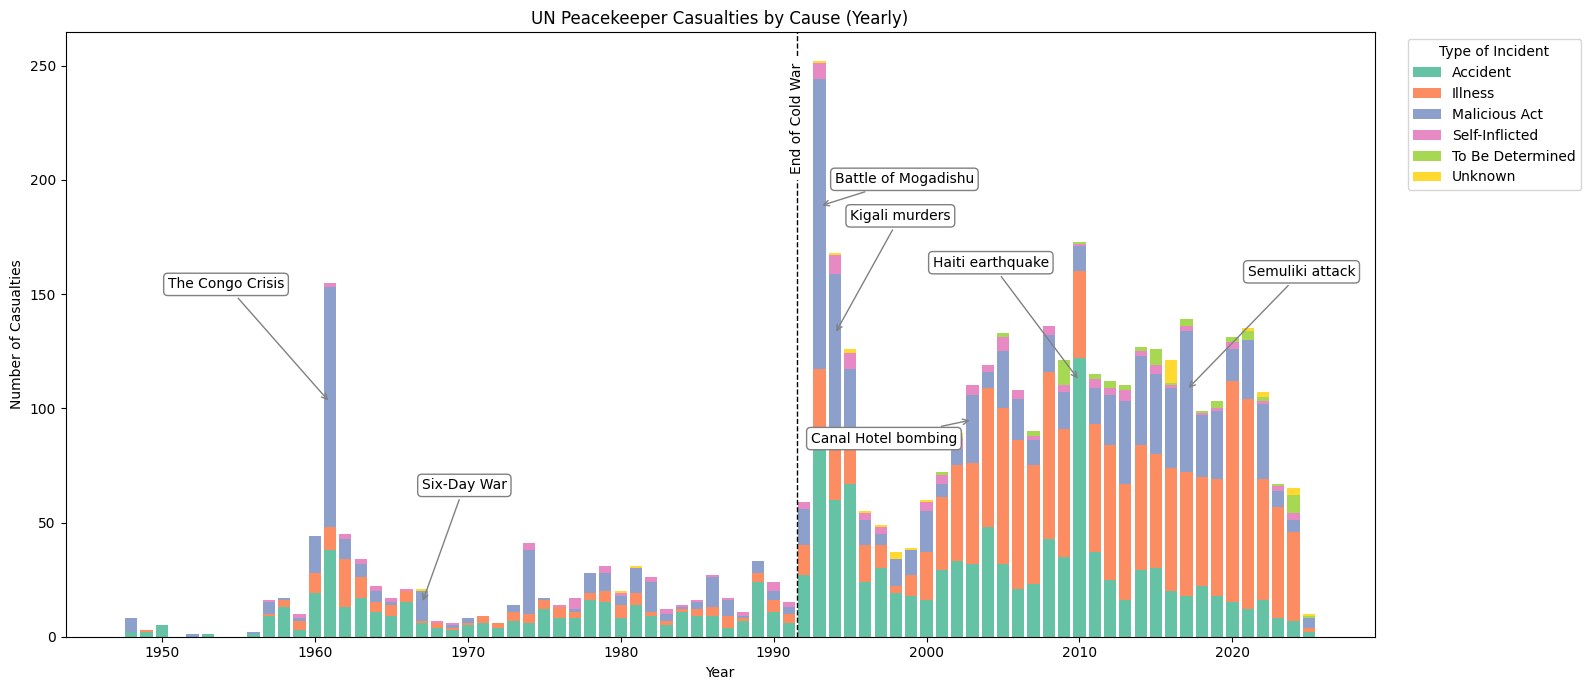

In [14]:
# Group by year and type_of_incident
df['year'] = df['incident_date'].dt.year
yearly = df.groupby(['year', 'type_of_incident']).size().unstack(fill_value=0)

# Sort columns for consistent stack order
yearly = yearly.sort_index()

# Create the plot
fig, ax = plt.subplots(figsize=(16, 7))

# Colors for incident types
incident_types = yearly.columns
cmap = plt.get_cmap('Set2')  # Or any distinct palette
color_dict = {inc: cmap(i % cmap.N) for i, inc in enumerate(incident_types)}

# Stacked bars
bottoms = pd.Series(0, index=yearly.index)
for inc in incident_types:
    ax.bar(yearly.index, yearly[inc], bottom=bottoms, label=inc, color=color_dict[inc])
    bottoms += yearly[inc]

# End of Cold War marker
ax.axvline(x=1991.5, color='black', linestyle='--', linewidth=1)
ax.text(1991.5, ax.get_ylim()[1]*0.95, 'End of Cold War', rotation=90,
        va='top', ha='center', fontsize=10, backgroundcolor='white')

annotations = [
    # year, type, label, x-offset, y-offset
    (1961, 'Malicious Act', 'The Congo Crisis', -3, 50),
    (1967, 'Malicious Act', 'Six-Day War', 0, 50),
    (1993, 'Malicious Act', 'Battle of Mogadishu', 1, 10),
    (1994, 'Malicious Act', 'Kigali murders', 1, 50),
    (2003, 'Malicious Act', 'Canal Hotel bombing', -1, -10),
    (2017, 'Malicious Act', 'Semuliki attack', 4, 50),
    (2010, 'Accident', 'Haiti earthquake', -2, 50),
]

for year, inc_type, label, dx, dy in annotations:
    try:
        height = yearly.loc[year, inc_type]
        bar_base = bottoms.loc[year] - height
        midpoint = bar_base + height / 2

        ax.annotate(label,
                    xy=(year, midpoint),
                    xytext=(year + dx, midpoint + dy),
                    arrowprops=dict(arrowstyle="->", color='gray'),
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=1),
                    fontsize=10,
                    ha='right' if dx < 0 else 'left')
    except KeyError:
        print(f"Missing data for {year}, {inc_type}")


# Formatting
ax.set_title("UN Peacekeeper Casualties by Cause (Yearly)")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Casualties")
ax.legend(title="Type of Incident", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
#plt.savefig("casualties_by_year.png", dpi=500, bbox_inches='tight') 
plt.show()
